In [20]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import Weibo2014
from moabb.datasets import Zhou2016
from moabb.datasets import BNCI2014004
from moabb.datasets import BNCI2014002
from moabb.datasets import BNCI2015001
from moabb.datasets import AlexMI
from moabb.datasets import bi2013a
from moabb.datasets import bi2014a
from moabb.datasets import bi2014b
from moabb.datasets import bi2015a
from moabb.datasets import bi2014b
from moabb.datasets import BNCI2014008
from moabb.datasets import BNCI2015003



from moabb.evaluations import WithinSessionEvaluation
from moabb.evaluations import CrossSessionEvaluation


import mne
from mne.preprocessing import Xdawn
from mne.decoding import CSP


from moabb.paradigms import MotorImagery
from moabb.paradigms import P300
from pyriemann.estimation import Covariances
from pyriemann.utils.covariance import covariances
from pyriemann.estimation import ERPCovariances
from pyriemann.estimation import XdawnCovariances
from pyriemann.classification import MDM
from pyriemann.classification import KNearestNeighbor
from pyriemann.tangentspace import TangentSpace
# from pyriemann.datasets import make_gaussian_blobs
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [4]:
paradigm = P300()
paradigm_name = 'P300'

In [5]:
pipelines = {}
pipelines["(1) erpcov-mdm-euc"] = make_pipeline(ERPCovariances("oas"), MDM(metric="euclid"))
pipelines["(2) erpcov-mdm-log"] = make_pipeline(ERPCovariances("oas"), MDM(metric="logeuclid"))
pipelines["(3) erpcov-mdm-rie"] = make_pipeline(ERPCovariances("oas"), MDM())
pipelines["(4) xdwcov-mdm-euc"] = make_pipeline(XdawnCovariances("oas"), MDM(metric="euclid"))
pipelines["(5) xdwcov-mdm-log"] = make_pipeline(XdawnCovariances("oas"), MDM(metric="logeuclid"))
pipelines["(6) xdwcov-mdm-rie"] = make_pipeline(XdawnCovariances("oas"), MDM())
# # #default riemannian
pipelines["(7) erpcov--tgs-lda"] = make_pipeline(ERPCovariances("oas"), TangentSpace(), LDA())
pipelines["(8) xdwcov-tgs-lda"] = make_pipeline(XdawnCovariances("oas"), TangentSpace(), LDA())
pipelines["(9) epo-xdw-lda"] = make_pipeline(Xdawn("oas"), LDA())
# # #(default: 'riemann')
#4, 8, 9


In [18]:
pipe = [pipelines["(1) erpcov-mdm-euc"], pipelines["(2) erpcov-mdm-log"], pipelines["(3) erpcov-mdm-rie"], pipelines["(4) xdwcov-mdm-euc"], pipelines["(5) xdwcov-mdm-log"], pipelines["(6) xdwcov-mdm-rie"], pipelines["(7) erpcov--tgs-lda"], pipelines["(8) xdwcov-tgs-lda"], pipelines["(9) epo-xdw-lda"]]
pipe_names = ["(1) erpcov-mdm-euc", "(2) erpcov-mdm-log", "(3) erpcov-mdm-rie", "(4) xdwcov-mdm-euc", "(5) xdwcov-mdm-log", "(6) xdwcov-mdm-rie", "(7) erpcov--tgs-lda", "(8) xdwcov-tgs-lda", "(9) epo-xdw-lda"]
datasets_names = ['BI.EEG.2014a', 'BI.EEG.2013a', 'BI.EEG.2015a', 'BNCI2015003',  'BNCI2014008']

In [24]:
scores_array = []
datasets = [BNCI2015003(),  BNCI2014008]
subj = [1, 2, 3, 4]
subject_source = 1
paradigm = paradigm
DSM = []
DSL = []
data_source = {}
for d in datasets:
    for p in pipe:
        X, labels, meta = paradigm.get_data(d, subjects=[subject_source])
        data_source['covs'], data_source['labels'] = Covariances('oas').fit_transform(X), labels
        DSM.append(data_source['covs'])
        DSL.append(data_source['labels'])
        scores_array.append(cross_val_score(p, data_source['covs'], data_source['labels'], cv=5, scoring='roc_auc').mean())
print(scores_array)

AssertionError: Dataset 003-2015 is not valid for paradigm

In [27]:
new_labels_names = []
labels = []
for i in range(len(DSL)):
    labels.append(pipelines[pipe_names[0]].fit(DSM[i], DSL[i]).classes_)
print(labels)

[array(['feet', 'right_hand'], dtype='<U32'), array(['feet', 'right_hand'], dtype='<U32'), array(['feet', 'right_hand'], dtype='<U32'), array(['feet', 'right_hand'], dtype='<U32'), array(['feet', 'right_hand'], dtype='<U32'), array(['feet', 'right_hand'], dtype='<U32'), array(['feet', 'right_hand'], dtype='<U32'), array(['left_hand', 'right_hand'], dtype='<U32'), array(['left_hand', 'right_hand'], dtype='<U32'), array(['left_hand', 'right_hand'], dtype='<U32'), array(['left_hand', 'right_hand'], dtype='<U32'), array(['left_hand', 'right_hand'], dtype='<U32'), array(['left_hand', 'right_hand'], dtype='<U32'), array(['left_hand', 'right_hand'], dtype='<U32')]


In [28]:
def split(n, p=0.8):
    TRAIN_idx = np.random.choice(n, int(p * n), replace=False) 
    TEST_idx = np.array(list(set(range(n)) - set(TRAIN_idx)))
    return TRAIN_idx, TEST_idx

print(split(10))

(array([5, 9, 8, 3, 0, 6, 2, 1]), array([4, 7]))


In [29]:
from sklearn.model_selection import KFold

def pred_truth(data_source_covs, data_source_labels, p, n_folds=5):
    if n_folds>1:
        cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        PREDICTION = []
        TRUTH = []
        for train, test in cv.split(data_source_covs):
            TRUTH.append(data_source_labels[test])
            model = p.fit(data_source_covs[train], data_source_labels[train])
            a = model.predict_proba(data_source_covs[test])
            PREDICTION.append(a)
        return PREDICTION, TRUTH
    PREDICTION = []
    TRUTH = []
    train = split(len(data_source_covs))[0]
    test = split(len(data_source_covs))[1]
    TRUTH.append(data_source_labels[test])
    model = p.fit(data_source_covs[train], data_source_labels[train])
    a = model.predict_proba(data_source_covs[test])
    PREDICTION.append(a)
    return PREDICTION, TRUTH


In [37]:
def counting(T):
    c = 0
    for i in range(len(T)):
        if T[i][0]>0.001 and T[i][0]<0.999:
            c+=1
    return c


C = [0 for i in range(len(pipe))]
for i in range(len(DSM)):
    x = 0
    p = pipe_names[i%len(pipe)]
    a = pred_truth(DSM[i], DSL[i], pipelines[p])[0]
    for j in range(len(a)):
        x+=counting(a[j])
    C[i%len(pipe)]+=x


Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 16 dim * 4.3e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 16 dim * 4.3e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4 (2.2e-16 eps * 16 dim * 3.8e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 16 dim * 4.3e+14  max singular value)
    Estimated ra

In [38]:
def mean(L):
    return sum(L)/len(L)

print(C, mean(C))

for i, elt in enumerate(C):
    if elt > mean(C):
        print(pipe_names[i%len(pipe)])

[1, 355, 3, 287, 1, 356, 217] 174.28571428571428
(4) epo-csp-lda
(6) cov-knn-rie
(8) cov-mdm-rie
(9) cov-tgs-lda


In [39]:
def roc_homemade(prediction, truth, threshold, i_data):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    prediction2 = False
    truth2 = False
    for i in range(len(prediction)):
        if prediction[i][0]>threshold:
            prediction2 = False
        else:
            prediction2 = True
        if truth[i] == labels[i_data][0]: #feet
            truth2 = False
        elif truth[i] == labels[i_data][1]: #right_hand
            truth2 = True
        if not(prediction2 or truth2):
            tp += 1
        elif prediction2 and truth2:
            tn += 1
        elif not prediction2 and truth2:
            fp += 1
        elif prediction2 and not truth2:
            fn += 1
    return tp, tn, fp, fn

def sensitivity(tp, tn, fp, fn):
    if tp+fn == 0:
        return 0
    return tp/(tp+fn)

def one_specificity(tp, tn, fp, fn):
    if fp+tn == 0:
        return 0
    return 1- (tn/(tn+fp))

def accuracy(tp, tn, fp, fn):
    return (tp+tn)/(tp+tn+fp+fn)


In [40]:
def accuracy_homemade(prediction, truth, i_data):
    prediction2 = True
    truth2 = True
    a = 0
    cpt = 0
    threshold = 0.5
    for i in range(len(prediction)):
        if prediction[i][0]>threshold:
            prediction2 = False
        else:
            prediction2 = True
        if truth[i] == labels[i_data][0]: #right_hand
            truth2 = False
        elif truth[i] == labels[i_data][1]:  #feet
            truth2 = True
        if prediction2 == truth2:
            cpt += 1
        a += 1
    return cpt/a

In [41]:
ACCURACY = []
for i in range(len(DSM)):
    p = pipe[i%len(pipe)]
    pred = pred_truth(DSM[i], DSL[i], p, n_folds=5)[0]
    truth = pred_truth(DSM[i], DSL[i], p, n_folds=5)[1]
    ACCURACY.append(mean([accuracy_homemade(pred[k_fold], truth[k_fold], i) for k_fold in range(5)]))

Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 16 dim * 4.3e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 16 dim * 4.3e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4 (2.2e-16 eps * 16 dim * 3.8e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 16 dim * 4.3e+14  max singular value)
    Estimated ra

In [48]:
def fct_roc(i_data, p, k_fold=0, n_folds=5):
    l_one_spec = []
    l_senstivity = []
    n= 100

    PREDICTION, TRUTH = pred_truth(DSM[i_data], DSL[i_data], p, n_folds=n_folds)
    for i in range(n):
        tp, tn, fp, fn = roc_homemade(predicton=PREDICTION[k_fold], truth=TRUTH[k_fold], threshold=i/n, pipe_data=i_data)
        l_one_spec.append(one_specificity(tp, tn, fp, fn))
        l_senstivity.append(sensitivity(tp, tn, fp, fn))
    return l_one_spec, l_senstivity

In [43]:

def print_fct_roc(i_data):
    n = 100
    THRESHOLD = [i/n for i in range(0,n)]
    p = pipe[i_data%len(pipe)]
    l_one_spec, l_senstivity = fct_roc(i_data, p, n_folds=1)
    plt.plot(l_one_spec, l_senstivity, label="roc")
    plt.plot(THRESHOLD, THRESHOLD, label="1ere bisansectrice des axes")
    plt.xlabel('1- Specificity')
    plt.ylabel('Sensitivity')
    plt.title(f"'{pipe_names[i_data%len(pipe)]}' {datasets_names[i_data//len(pipe_names)]}")
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    plt.legend()
    plt.show()

In [44]:
def auc_roc(l_one_spec, l_senstivity):
    auc = 0
    for i in range(len(l_one_spec)-1):
        auc += (l_one_spec[i+1]-l_one_spec[i])*(l_senstivity[i+1]+l_senstivity[i])/2
    return abs(auc)
AUC = []
for i_data in range(len(DSM)):
    p = pipe[i_data%len(pipe)]
    AUC.append(mean([auc_roc(fct_roc(i_data, p, k_fold)[0], fct_roc(i_data, p, k_fold)[1]) for k_fold in range(5)]))

Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 16 dim * 4.3e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 16 dim * 4.3e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4 (2.2e-16 eps * 16 dim * 3.8e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 16 dim * 4.3e+14  max singular value)
    Estimated ra

In [45]:
T_ACCURACY = []
cpt = 0
for elt in ACCURACY:
    if elt < 0.5:
        cpt += 1
        T_ACCURACY.append(1-elt)
    else:
        T_ACCURACY.append(elt)
print(cpt)
print(ACCURACY)
#print(T_ACCURACY)
print(AUC)

3
[0.425, 0.45, 0.6, 0.6, 0.475, 0.65, 0.825, 0.5642857142857143, 0.8368055555555556, 0.6018849206349206, 0.6896329365079366, 0.554861111111111, 0.6709325396825397, 0.7960813492063492]
[0.2458333333333333, 0.4091666666666667, 0.38875, 0.6224999999999999, 0.24666666666666665, 0.6308333333333334, 0.8983333333333334, 0.02374335853598527, 0.9102541832807169, 0.07764380037205497, 0.5620579858669397, 0.0, 0.7389080106321609, 0.8569420901379248]


In [37]:
import csv

with open('results_data.csv', 'w', newline='') as csvfile:
    fieldnames = ['count', 'auc_roc_score', 'accuracy', 'subject','dataset', 'pipeline']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(len(AUC)):
        writer.writerow({'count': i, 'auc_roc_score': AUC[i], 'accuracy': T_ACCURACY[i], 'subject': 1, 'dataset': f'{datasets_names[i//len(pipe)]}', 'pipeline': pipe_names[i%len(pipe)]})


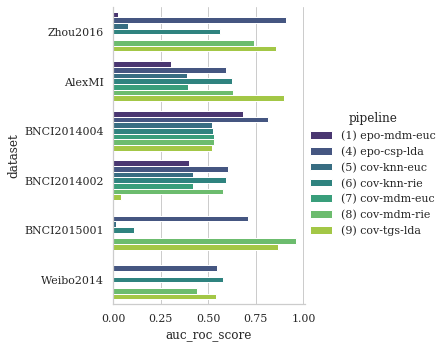

In [38]:
data = pd.read_csv('results_data.csv')

sns.catplot(
    y="dataset", x="auc_roc_score", hue="pipeline", data=data, orient="h", palette="viridis", kind="bar"
)